In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

MedQA

GPT3.5

In [156]:
df_vanilla = pd.read_parquet("results/medqa_gpt-3.5-turbo_vanilla_base_all_00:18:36.parquet")
df_cot = pd.read_parquet("results/medqa_gpt-3.5-turbo_cot_base_all_02:09:33.parquet")
df_atypical_scenario = pd.read_parquet("results/medqa_gpt-3.5-turbo_atypical-situation_base_all_21:36:22.parquet")
df_atypical_presentations = pd.read_parquet("results/medqa_gpt-3.5-turbo_atypical_base_all_01:18:19.parquet")
df_consistency = pd.read_parquet("results/medqa_gpt-3.5-turbo_vanilla_consistency_all_23:56:41.parquet")
df_average = pd.read_parquet("results/medqa_gpt-3.5-turbo_vanilla_average_all_08:02:00.parquet")

In [157]:
df_vanilla_medmcqa = pd.read_parquet("results/medmcqa_gpt-3.5-turbo_vanilla_base_all_02:04:08.parquet")
df_cot_medmcqa = pd.read_parquet("results/medmcqa_gpt-3.5-turbo_cot_base_all_03:17:16.parquet")
df_atypical_presentations_medmcqa = pd.read_parquet("results/medmcqa_gpt-3.5-turbo_atypical_base_all_02:37:42.parquet")
df_atypical_scenario_medmcqa = pd.read_parquet("results/medmcqa_gpt-3.5-turbo_atypical-situation_base_all_22:37:14.parquet")
df_consistency_medmcqa = pd.read_parquet("results/medmcqa_gpt-3.5-turbo_vanilla_consistency_all_00:55:37.parquet")
df_average_medmcqa = pd.read_parquet("results/medmcqa_gpt-4-turbo_vanilla_average_all_19:54:42.parquet")

In [171]:
df_atypical_presentations_medmcqa.head()

,Questions,Difficulty Score,Mean Difficulty Score,Correct Answers,Majority Predicted Answer,All Predicted Answers,Final Prediction,Consistency Confidence,Average Vanilla Confidence,Average Confidence,All Vanilla Confidence Scores,All Confidence Scores,Ground Truth Probability,Atypicality,atypicality_bin
0,A 29 yrs old woman with a pregnancy of 17 week...,[7],7.0,C,C,[C],C,1.0,1.0,1.0,[80],[69.50748425900355],1.0,0.859408,"(0.612, 0.917]"
1,"Concentration of tropicamide: A:0.01, B:0.02, ...",[4],4.0,A,B,[B],B,1.0,1.0,1.0,[90],[81.14693984353424],0.0,0.896452,"(0.612, 0.917]"
2,Which of the following are not a branch of ext...,[3],3.0,B,C,[C],C,1.0,1.0,1.0,[95],[89.74651859794587],0.0,0.943112,"(0.917, 1.223]"
3,Diagnosis of the following ECG- A:Ventricular ...,[6],6.0,B,A,[A],A,1.0,1.0,1.0,[80],[55.06421767910961],0.0,0.626473,"(0.612, 0.917]"
4,27.\tThe lateral spread of dental caries is fa...,[5],5.0,B,B,[B],B,1.0,1.0,1.0,[80],[57.15395991050107],1.0,0.663722,"(0.612, 0.917]"


In [158]:
df_vanilla_pubmedqa = pd.read_parquet("results/pubmedqa_gpt-3.5-turbo_vanilla_base_all_01:46:30.parquet")
df_cot_pubmedqa = pd.read_parquet("results/pubmedqa_gpt-3.5-turbo_cot_base_all_20:28:44.parquet")
df_atypical_presentations_pubmedqa = pd.read_parquet("results/pubmedqa_gpt-3.5-turbo_atypical_base_all_11:30:19.parquet")
df_atypical_scenario_pubmedqa = pd.read_parquet("results/pubmedqa_gpt-3.5-turbo_atypical-situation_base_all_02:16:31.parquet")
df_consistency_pubmedqa = pd.read_parquet("results_mac/pubmedqa_gpt-3.5-turbo_vanilla_consistency_all_170855.parquet")
df_average_pubmedqa = pd.read_parquet("results_mac/pubmedqa_gpt-3.5-turbo_vanilla_average_all_184107.parquet")

In [159]:
df_consistency['Binary Ground Truth'] = (df_consistency['Ground Truth Probability'] >= 0.5).astype(int)
df_average['Binary Ground Truth'] = (df_average['Ground Truth Probability'] >= 0.5).astype(int)

df_consistency_medmcqa['Binary Ground Truth'] = (df_consistency_medmcqa['Ground Truth Probability'] >= 0.5).astype(int)
df_average_medmcqa['Binary Ground Truth'] = (df_average_medmcqa['Ground Truth Probability'] >= 0.5).astype(int)

df_consistency_pubmedqa['Binary Ground Truth'] = (df_consistency_pubmedqa['Ground Truth Probability'] >= 0.5).astype(int)
df_average_pubmedqa['Binary Ground Truth'] = (df_average_pubmedqa['Ground Truth Probability'] >= 0.5).astype(int)

In [172]:
def compute_atypical_scores(row):
    confidence_score = row['All Vanilla Confidence Scores'][0]
    calibrated_confidence = row['All Confidence Scores'][0]
    if row['All Confidence Scores'][0] > 100:
        calibrated_confidence = 100
    atypical_scores = np.log(calibrated_confidence / confidence_score) + 1
    if atypical_scores > 1:
        return 1
    elif atypical_scores < 0:
        return 0
    else:
        return atypical_scores

In [173]:
df_vanilla['Atypicality'] = df_vanilla.apply(compute_atypical_scores, axis=1)
df_cot['Atypicality'] = df_cot.apply(compute_atypical_scores, axis=1)
df_atypical_scenario['Atypicality'] = df_atypical_scenario.apply(compute_atypical_scores, axis=1)
df_atypical_presentations['Atypicality'] = df_atypical_presentations.apply(compute_atypical_scores, axis=1)
df_consistency['Atypicality'] = df_consistency.apply(compute_atypical_scores, axis=1)
df_average['Atypicality'] = df_average.apply(compute_atypical_scores, axis=1)

df_vanilla_medmcqa['Atypicality'] = df_vanilla_medmcqa.apply(compute_atypical_scores, axis=1)
df_cot_medmcqa['Atypicality'] = df_cot_medmcqa.apply(compute_atypical_scores, axis=1)
df_atypical_scenario_medmcqa['Atypicality'] = df_atypical_scenario_medmcqa.apply(compute_atypical_scores, axis=1)
df_atypical_presentations_medmcqa['Atypicality'] = df_atypical_presentations_medmcqa.apply(compute_atypical_scores, axis=1)
df_consistency_medmcqa['Atypicality'] = df_consistency_medmcqa.apply(compute_atypical_scores, axis=1)
df_average_medmcqa['Atypicality'] = df_average_medmcqa.apply(compute_atypical_scores, axis=1)

df_vanilla_pubmedqa['Atypicality'] = df_vanilla_pubmedqa.apply(compute_atypical_scores, axis=1)
df_cot_pubmedqa['Atypicality'] = df_cot_pubmedqa.apply(compute_atypical_scores, axis=1)
df_atypical_scenario_pubmedqa['Atypicality'] = df_atypical_scenario_pubmedqa.apply(compute_atypical_scores, axis=1)
df_atypical_presentations_pubmedqa['Atypicality'] = df_atypical_presentations_pubmedqa.apply(compute_atypical_scores, axis=1)
df_consistency_pubmedqa['Atypicality'] = df_consistency_pubmedqa.apply(compute_atypical_scores, axis=1)
df_average_pubmedqa['Atypicality'] = df_average_pubmedqa.apply(compute_atypical_scores, axis=1)

In [174]:
prob_true, prob_pred = calibration_curve(df_vanilla['Ground Truth Probability'], df_vanilla['All Vanilla Confidence Scores'].apply(lambda x: min(x[0], 100)/100), n_bins=10)

In [175]:
prob_true_medmcqa, prob_pred_medmcqa = calibration_curve(df_vanilla_medmcqa['Ground Truth Probability'], df_vanilla_medmcqa['All Vanilla Confidence Scores'].apply(lambda x: min(x[0], 100)/100), n_bins=10)
prob_true_pubmedqa, prob_pred_pubmedqa = calibration_curve(df_vanilla_pubmedqa['Ground Truth Probability'], df_vanilla_pubmedqa['All Vanilla Confidence Scores'].apply(lambda x: min(x[0], 100)/100), n_bins=10)

In [176]:
prob_true_cot, prob_pred_cot = calibration_curve(df_cot['Ground Truth Probability'], df_cot['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100), n_bins=10)
prob_true_atypical_scenario, prob_pred_atypical_scenario = calibration_curve(df_atypical_scenario['Ground Truth Probability'], df_atypical_scenario['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100), n_bins=10)
prob_true_atypical_presentations, prob_pred_presentations = calibration_curve(df_atypical_presentations['Ground Truth Probability'], df_atypical_presentations['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100), n_bins=10)
prob_true_consistency, prob_pred_consistency = calibration_curve(df_consistency['Binary Ground Truth'], df_consistency['Consistency Confidence'], n_bins=10)
prob_true_average, prob_pred_average = calibration_curve(df_average['Binary Ground Truth'], df_average['Average Confidence'], n_bins=10)                   

In [177]:
prob_true_cot_medmcqa, prob_pred_cot_medmcqa = calibration_curve(df_cot_medmcqa['Ground Truth Probability'], df_cot_medmcqa['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100), n_bins=10)
prob_true_atypical_scenario_medmcqa, prob_pred_atypical_scenario_medmcqa = calibration_curve(df_atypical_scenario_medmcqa['Ground Truth Probability'], df_atypical_scenario_medmcqa['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100), n_bins=10)
prob_true_atypical_presentations_medmcqa, prob_pred_presentations_medmcqa = calibration_curve(df_atypical_presentations_medmcqa['Ground Truth Probability'], df_atypical_presentations_medmcqa['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100), n_bins=10)
prob_true_consistency_medmcqa, prob_pred_consistency_medmcqa = calibration_curve(df_consistency_medmcqa['Binary Ground Truth'], df_consistency_medmcqa['Consistency Confidence'], n_bins=10)
prob_true_average_medmcqa, prob_pred_average_medmcqa = calibration_curve(df_average_medmcqa['Binary Ground Truth'], df_average_medmcqa['Average Confidence'], n_bins=10)                

prob_true_cot_pubmedqa, prob_pred_cot_pubmedqa = calibration_curve(df_cot_pubmedqa['Ground Truth Probability'], df_cot_pubmedqa['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100), n_bins=10)
prob_true_atypical_scenario_pubmedqa, prob_pred_atypical_scenario_pubmedqa = calibration_curve(df_atypical_scenario_pubmedqa['Ground Truth Probability'], df_atypical_scenario_pubmedqa['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100), n_bins=10)
prob_true_atypical_presentations_pubmedqa, prob_pred_presentations_pubmedqa = calibration_curve(df_atypical_presentations_pubmedqa['Ground Truth Probability'], df_atypical_presentations_pubmedqa['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100), n_bins=10)
prob_true_consistency_pubmedqa, prob_pred_consistency_pubmedqa = calibration_curve(df_consistency_pubmedqa['Binary Ground Truth'], df_consistency_pubmedqa['Consistency Confidence'], n_bins=10)
prob_true_average_pubmedqa, prob_pred_average_pubmedqa = calibration_curve(df_average_pubmedqa['Binary Ground Truth'], df_average_pubmedqa['Average Confidence'], n_bins=10)                

In [178]:
def set_tick_params(ax):
    ax.tick_params(axis='both', which='major', labelsize=24)

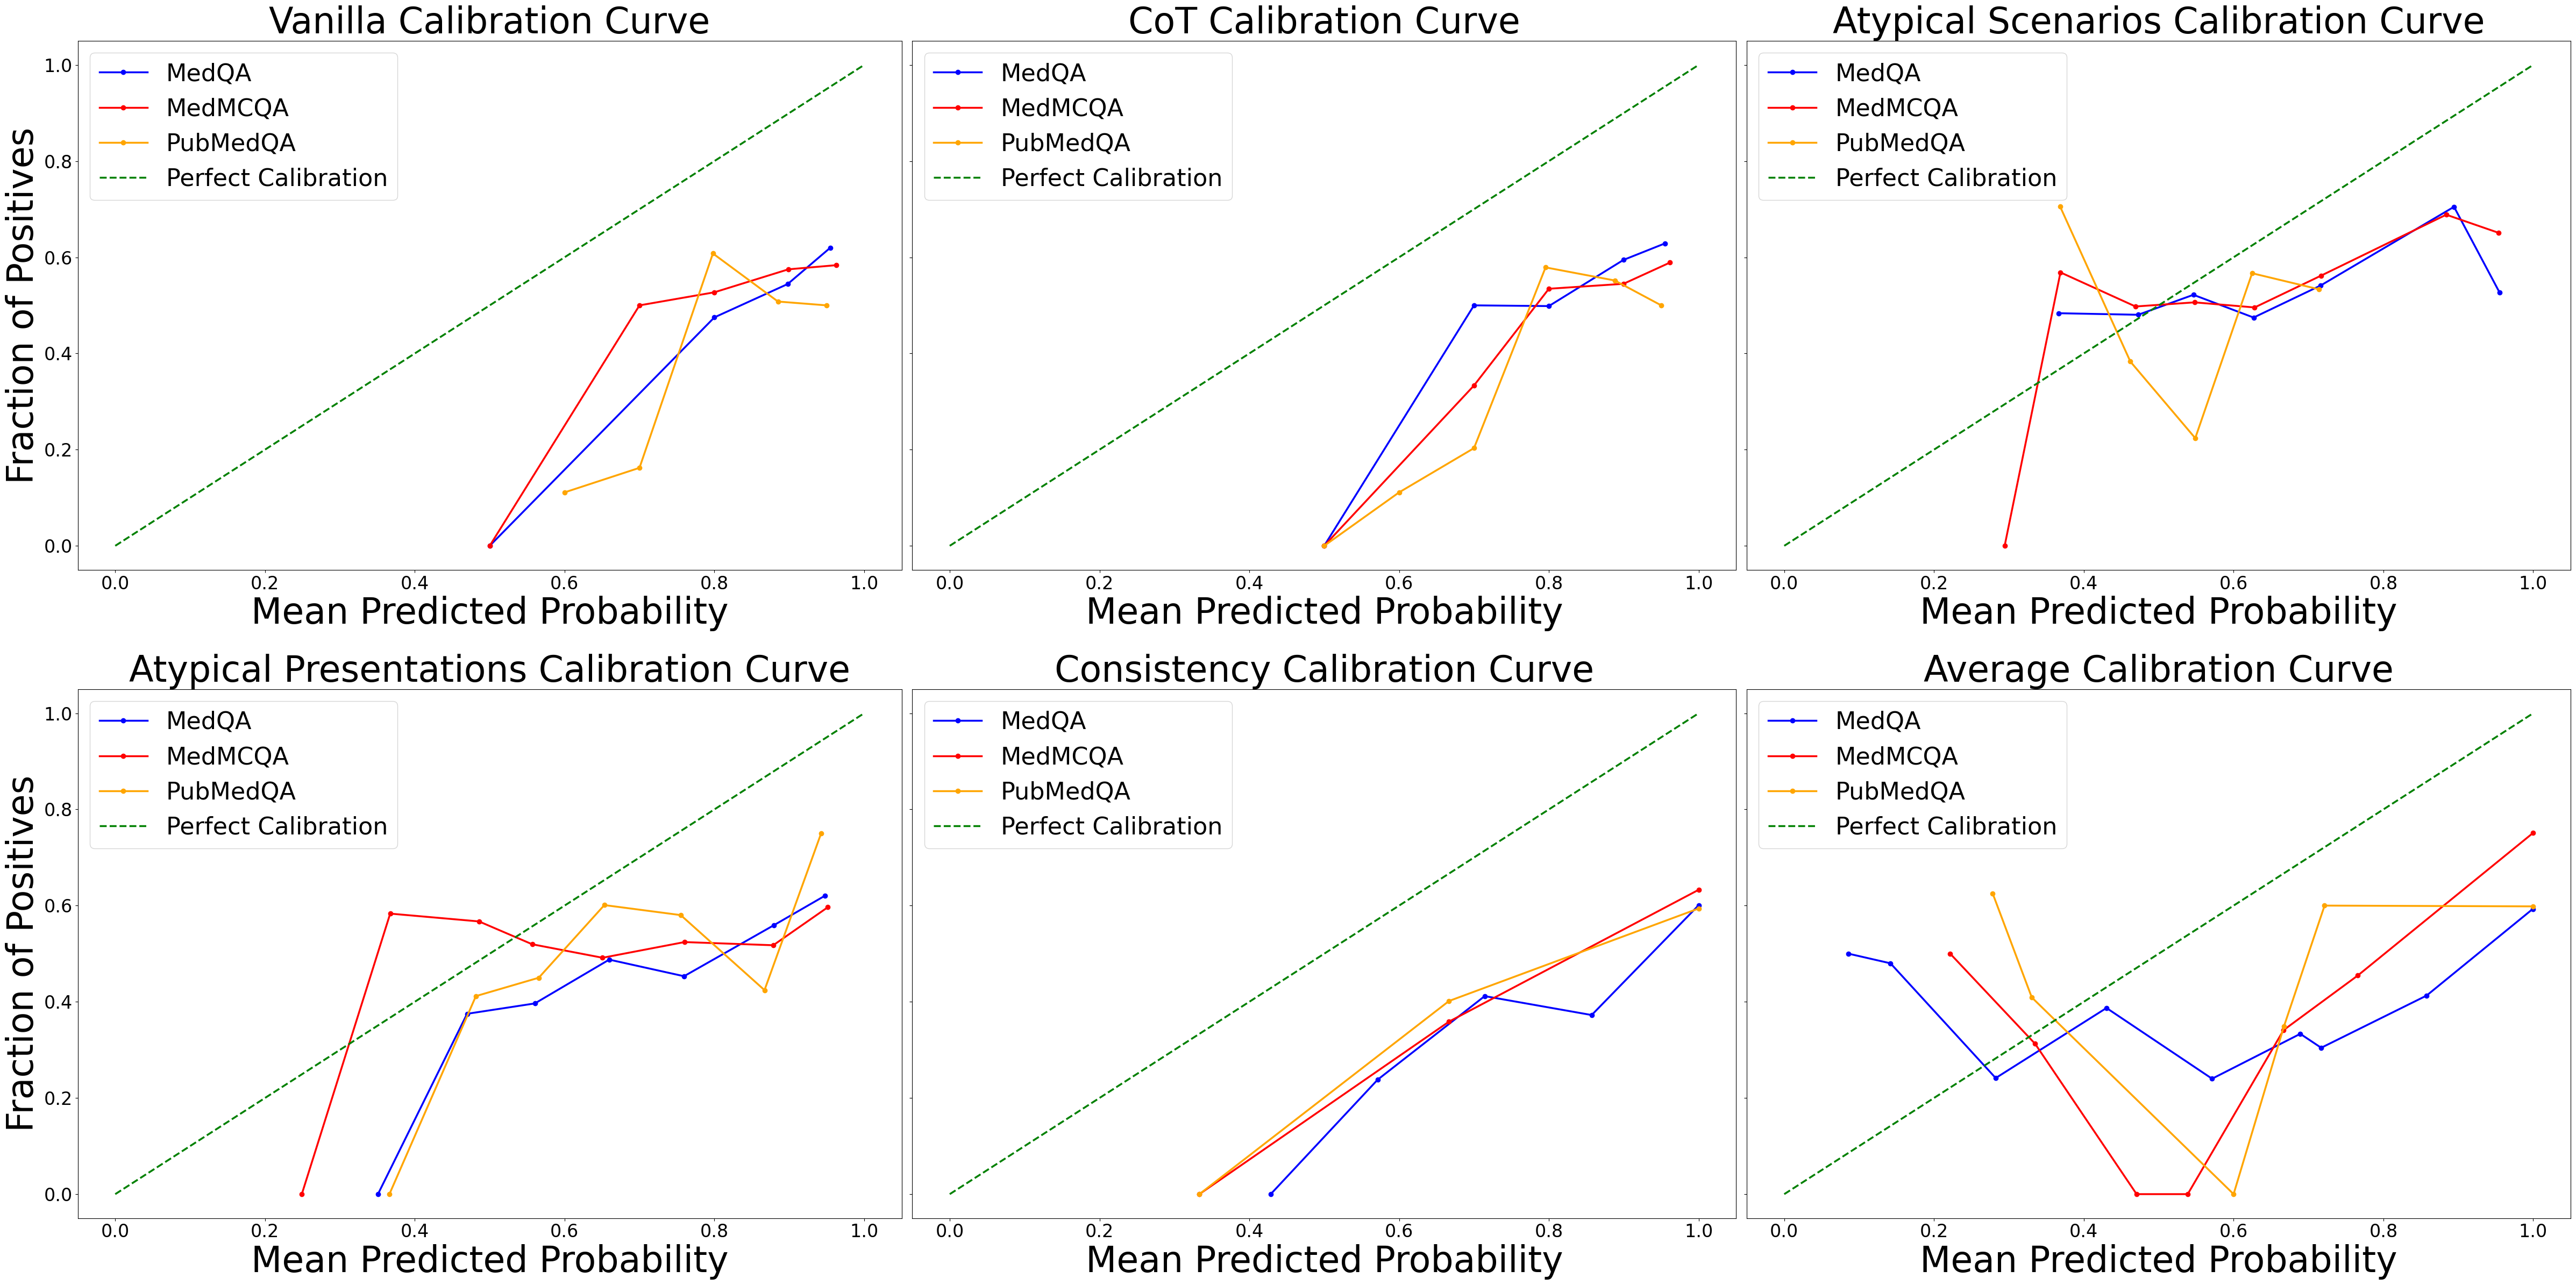

In [179]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(48, 24), sharey=True)

# Define colors for each plot
colors = ['blue', 'red', 'purple', 'orange', 'brown', 'black']

# Plot each calibration curve in its own subplot with specified colors
axs[0, 0].plot(prob_pred, prob_true, marker='o', linewidth=2.5, color=colors[0], label='MedQA')
axs[0, 0].plot(prob_pred_medmcqa, prob_true_medmcqa, marker='o', linewidth=2.5, color="red", label='MedMCQA')
axs[0, 0].plot(prob_pred_pubmedqa, prob_true_pubmedqa, marker='o', linewidth=2.5, color="orange", label='PubMedQA')
axs[0, 0].plot([0, 1], [0, 1], linestyle='--', linewidth=2.5, color='green', label='Perfect Calibration')
axs[0, 0].set_title('Vanilla Calibration Curve', fontsize=48)
axs[0, 0].set_xlabel('Mean Predicted Probability', fontsize=48)
axs[0, 0].set_ylabel('Fraction of Positives', fontsize=48)
axs[0, 0].legend(loc='best', fontsize=32)
set_tick_params(axs[0, 0])

axs[0, 1].plot(prob_pred_cot, prob_true_cot, marker='o', linewidth=2.5, color=colors[0], label='MedQA')
axs[0, 1].plot(prob_pred_cot_medmcqa, prob_true_cot_medmcqa, marker='o', linewidth=2.5, color="red", label='MedMCQA')
axs[0, 1].plot(prob_pred_cot_pubmedqa, prob_true_cot_pubmedqa, marker='o', linewidth=2.5, color="orange", label='PubMedQA')
axs[0, 1].plot([0, 1], [0, 1], linestyle='--', linewidth=2.5, color='green', label='Perfect Calibration')
axs[0, 1].set_title('CoT Calibration Curve', fontsize=48)
axs[0, 1].set_xlabel('Mean Predicted Probability', fontsize=48)
axs[0, 1].legend(loc='best', fontsize=32)
set_tick_params(axs[0, 1])

axs[0, 2].plot(prob_pred_atypical_scenario, prob_true_atypical_scenario, marker='o', linewidth=2.5, color=colors[0], label='MedQA')
axs[0, 2].plot(prob_pred_atypical_scenario_medmcqa, prob_true_atypical_scenario_medmcqa, marker='o', linewidth=2.5, color="red", label='MedMCQA')
axs[0, 2].plot(prob_pred_atypical_scenario_pubmedqa, prob_true_atypical_scenario_pubmedqa, marker='o', linewidth=2.5, color="orange", label='PubMedQA')
axs[0, 2].plot([0, 1], [0, 1], linestyle='--', linewidth=2.5, color='green', label='Perfect Calibration')
axs[0, 2].set_title('Atypical Scenarios Calibration Curve', fontsize=48)
axs[0, 2].set_xlabel('Mean Predicted Probability', fontsize=48)
axs[0, 2].legend(loc='best', fontsize=32)
set_tick_params(axs[0, 2])

axs[1, 0].plot(prob_pred_presentations, prob_true_atypical_presentations, marker='o', linewidth=2.5, color=colors[0], label='MedQA')
axs[1, 0].plot(prob_pred_presentations_medmcqa, prob_true_atypical_presentations_medmcqa, marker='o', linewidth=2.5, color="red", label='MedMCQA')
axs[1, 0].plot(prob_pred_presentations_pubmedqa, prob_true_atypical_presentations_pubmedqa, marker='o', linewidth=2.5, color="orange", label='PubMedQA')
axs[1, 0].plot([0, 1], [0, 1], linestyle='--', linewidth=2.5, color='green', label='Perfect Calibration')
axs[1, 0].set_title('Atypical Presentations Calibration Curve', fontsize=48)
axs[1, 0].set_xlabel('Mean Predicted Probability', fontsize=48)
axs[1, 0].set_ylabel('Fraction of Positives', fontsize=48)
axs[1, 0].legend(loc='best', fontsize=32)
set_tick_params(axs[1, 0])

axs[1, 1].plot(prob_pred_consistency, prob_true_consistency, marker='o', linewidth=2.5, color=colors[0], label='MedQA')
axs[1, 1].plot(prob_pred_consistency_medmcqa, prob_true_consistency_medmcqa, marker='o', linewidth=2.5, color="red", label='MedMCQA')
axs[1, 1].plot(prob_pred_consistency_pubmedqa, prob_true_consistency_pubmedqa, marker='o', linewidth=2.5, color="orange", label='PubMedQA')
axs[1, 1].plot([0, 1], [0, 1], linestyle='--', linewidth=2.5, color='green', label='Perfect Calibration')
axs[1, 1].set_title('Consistency Calibration Curve', fontsize=48)
axs[1, 1].set_xlabel('Mean Predicted Probability', fontsize=48)
axs[1, 1].legend(loc='best', fontsize=32)
set_tick_params(axs[1, 1])

axs[1, 2].plot(prob_pred_average, prob_true_average, marker='o', linewidth=2.5, color=colors[0], label='MedQA')
axs[1, 2].plot(prob_pred_average_medmcqa, prob_true_average_medmcqa, marker='o', linewidth=2.5, color="red", label='MedMCQA')
axs[1, 2].plot(prob_pred_average_pubmedqa, prob_true_average_pubmedqa, marker='o', linewidth=2.5, color="orange", label='PubMedQA')
axs[1, 2].plot([0, 1], [0, 1], linestyle='--', linewidth=2.5, color='green', label='Perfect Calibration')
axs[1, 2].set_title('Average Calibration Curve', fontsize=48)
axs[1, 2].set_xlabel('Mean Predicted Probability', fontsize=48)
axs[1, 2].legend(loc='best', fontsize=32)
set_tick_params(axs[1, 2])

# Adjust layout
plt.tight_layout(h_pad=3.0) 
plt.savefig('graphs/calibration_curves.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


In [202]:
# Bin the atypicality scores
num_bins = 5

bins_scenario = np.linspace(df_atypical_scenario['Atypicality'].min(), df_atypical_scenario['Atypicality'].max(), num_bins + 1)
df_atypical_scenario['atypicality_bin'] = pd.cut(df_atypical_scenario['Atypicality'], bins_scenario, include_lowest=True)

bins_presentations = np.linspace(df_atypical_presentations['Atypicality'].min(), df_atypical_presentations['Atypicality'].max(), num_bins + 1)
df_atypical_presentations['atypicality_bin'] = pd.cut(df_atypical_presentations['Atypicality'], bins_presentations, include_lowest=True)

In [207]:
num_bins_medmcqa = 3

bins_scenario_medmcqa = np.linspace(df_atypical_scenario_medmcqa['Atypicality'].min(), df_atypical_scenario_medmcqa['Atypicality'].max(), num_bins_medmcqa + 1)
df_atypical_scenario_medmcqa['atypicality_bin'] = pd.cut(df_atypical_scenario_medmcqa['Atypicality'], bins_scenario_medmcqa, include_lowest=True)

bins_presentations_medmcqa = np.linspace(df_atypical_presentations_medmcqa['Atypicality'].min(), df_atypical_presentations_medmcqa['Atypicality'].max(), num_bins_medmcqa + 1)
df_atypical_presentations_medmcqa['atypicality_bin'] = pd.cut(df_atypical_presentations_medmcqa['Atypicality'], bins_presentations_medmcqa, include_lowest=True)

In [200]:
num_bins = 5

bins_scenario_pubmedqa = np.linspace(df_atypical_scenario_pubmedqa['Atypicality'].min(), df_atypical_scenario_pubmedqa['Atypicality'].max(), num_bins + 1)
df_atypical_scenario_pubmedqa['atypicality_bin'] = pd.cut(df_atypical_scenario_pubmedqa['Atypicality'], bins_scenario_pubmedqa, include_lowest=True)

bins_presentations_pubmedqa = np.linspace(df_atypical_presentations_pubmedqa['Atypicality'].min(), df_atypical_presentations_pubmedqa['Atypicality'].max(), num_bins + 1)
df_atypical_presentations_pubmedqa['atypicality_bin'] = pd.cut(df_atypical_presentations_pubmedqa['Atypicality'], bins_presentations_pubmedqa, include_lowest=True)

In [216]:
def calculate_ece(df, bin_column, prob_column, true_label_column):
    ece = []
    bins = df[bin_column].unique()
    for bin in bins:
        bin_data = df[df[bin_column] == bin]
        bin_prob = bin_data[prob_column]
        bin_true = bin_data[true_label_column]
        bin_ece = np.abs(bin_prob.mean() - bin_true.mean())
        ece.append(bin_ece)
    return pd.Series(ece, index=bins)

In [218]:
df_atypical_scenario['Calibrated Confidence'] = df_atypical_scenario['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100)
df_atypical_presentations['Calibrated Confidence'] = df_atypical_presentations['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100)

df_atypical_scenario_medmcqa['Calibrated Confidence'] = df_atypical_scenario_medmcqa['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100)
df_atypical_presentations_medmcqa['Calibrated Confidence'] = df_atypical_presentations_medmcqa['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100)

df_atypical_scenario_pubmedqa['Calibrated Confidence'] = df_atypical_scenario_pubmedqa['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100)
df_atypical_presentations_pubmedqa['Calibrated Confidence'] = df_atypical_presentations_pubmedqa['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100)

In [141]:
df_atypical_scenario_medmcqa['Calibrated Confidence'] = df_atypical_scenario_medmcqa['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100)
df_atypical_presentations_medmcqa['Calibrated Confidence'] = df_atypical_presentations_medmcqa['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100)
df_atypical_scenario_pubmedqa['Calibrated Confidence'] = df_atypical_scenario_pubmedqa['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100)
df_atypical_presentations_pubmedqa['Calibrated Confidence'] = df_atypical_presentations_pubmedqa['All Confidence Scores'].apply(lambda x: min(x[0], 100)/100)

In [219]:
# Calculate ECE for each bin
ece_scenario = calculate_ece(df_atypical_scenario, 'atypicality_bin', 'Calibrated Confidence', 'Ground Truth Probability')
ece_presentations = calculate_ece(df_atypical_presentations, 'atypicality_bin', 'Calibrated Confidence', 'Ground Truth Probability')

ece_scenario_medmcqa = calculate_ece(df_atypical_scenario_medmcqa, 'atypicality_bin', 'Calibrated Confidence', 'Ground Truth Probability')
ece_presentations_medmcqa = calculate_ece(df_atypical_presentations_medmcqa, 'atypicality_bin', 'Calibrated Confidence', 'Ground Truth Probability')

ece_scenario_pubmedqa = calculate_ece(df_atypical_scenario_pubmedqa, 'atypicality_bin', 'Calibrated Confidence', 'Ground Truth Probability')
ece_presentations_pubmedqa = calculate_ece(df_atypical_presentations_pubmedqa, 'atypicality_bin', 'Calibrated Confidence', 'Ground Truth Probability')

In [208]:
# Calculate mean accuracy within each atypicality bin
df_atypical_scenario['accuracy'] = df_atypical_scenario['Ground Truth Probability']
df_atypical_presentations['accuracy'] = df_atypical_presentations['Ground Truth Probability']

mean_accuracy_scenario = df_atypical_scenario.groupby('atypicality_bin')['accuracy'].mean()
mean_accuracy_presentations = df_atypical_presentations.groupby('atypicality_bin')['accuracy'].mean()

# Get the bin centers
bin_centers_scenario = [interval.mid for interval in mean_accuracy_scenario.index]
bin_centers_presentations = [interval.mid for interval in mean_accuracy_presentations.index]

# Calculate mean accuracy within each atypicality bin
df_atypical_scenario_medmcqa['accuracy'] = df_atypical_scenario_medmcqa['Ground Truth Probability']
df_atypical_presentations_medmcqa['accuracy'] = df_atypical_presentations_medmcqa['Ground Truth Probability']

mean_accuracy_scenario_medmcqa = df_atypical_scenario_medmcqa.groupby('atypicality_bin')['accuracy'].mean()
mean_accuracy_presentations_medmcqa = df_atypical_presentations_medmcqa.groupby('atypicality_bin')['accuracy'].mean()

# Get the bin centers
bin_centers_scenario_medmcqa = [interval.mid for interval in mean_accuracy_scenario_medmcqa.index]
bin_centers_presentations_medmcqa = [interval.mid for interval in mean_accuracy_presentations_medmcqa.index]

# Calculate mean accuracy within each atypicality bin
df_atypical_scenario_pubmedqa['accuracy'] = df_atypical_scenario_pubmedqa['Ground Truth Probability']
df_atypical_presentations_pubmedqa['accuracy'] = df_atypical_presentations_pubmedqa['Ground Truth Probability']

mean_accuracy_scenario_pubmedqa = df_atypical_scenario_pubmedqa.groupby('atypicality_bin')['accuracy'].mean()
mean_accuracy_presentations_pubmedqa = df_atypical_presentations_pubmedqa.groupby('atypicality_bin')['accuracy'].mean()

# Get the bin centers
bin_centers_scenario_pubmedqa = [interval.mid for interval in mean_accuracy_scenario_pubmedqa.index]
bin_centers_presentations_pubmedqa = [interval.mid for interval in mean_accuracy_presentations_pubmedqa.index]

/tmp/ipykernel_124655/1560826388.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy_scenario = df_atypical_scenario.groupby('atypicality_bin')['accuracy'].mean()
/tmp/ipykernel_124655/1560826388.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy_presentations = df_atypical_presentations.groupby('atypicality_bin')['accuracy'].mean()
/tmp/ipykernel_124655/1560826388.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default an

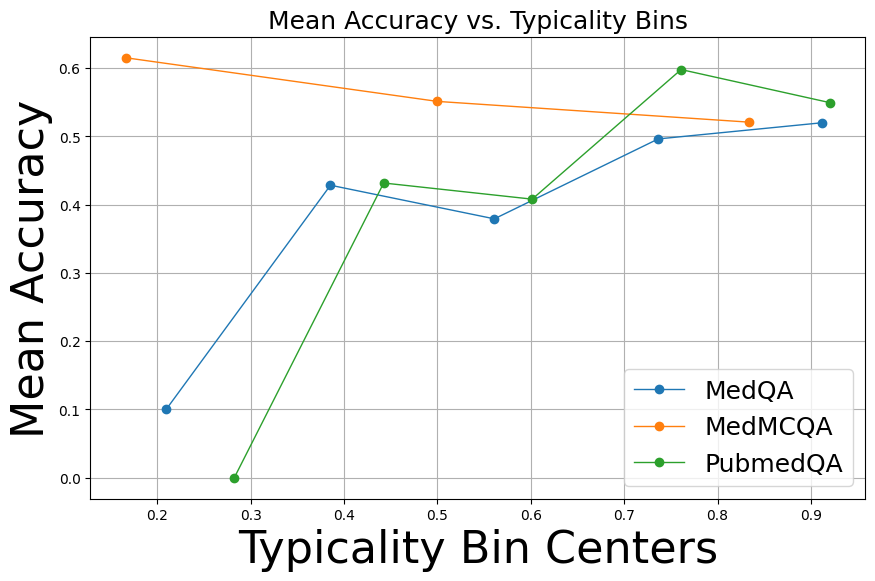

In [230]:
# Plot mean accuracy against atypicality bins
plt.figure(figsize=(10, 6))
# plt.plot(bin_centers_scenario, mean_accuracy_scenario.values, marker='o', linewidth=1, label="Atypical Scenario")
plt.plot(bin_centers_presentations, mean_accuracy_presentations.values, marker='o', linewidth=1, label="MedQA")
plt.plot(bin_centers_presentations_medmcqa, mean_accuracy_presentations_medmcqa.values, marker='o', linewidth=1, label="MedMCQA")
plt.plot(bin_centers_presentations_pubmedqa, mean_accuracy_presentations_pubmedqa.values, marker='o', linewidth=1, label="PubmedQA")
plt.xlabel('Typicality Bin Centers', fontsize=32)
plt.ylabel('Mean Accuracy', fontsize=32)
plt.title('Mean Accuracy vs. Typicality Bins', fontsize=18)
plt.grid(True)
plt.legend(loc='lower right', fontsize=18)
plt.savefig('graphs/acc_vs_atypicality_presentations.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

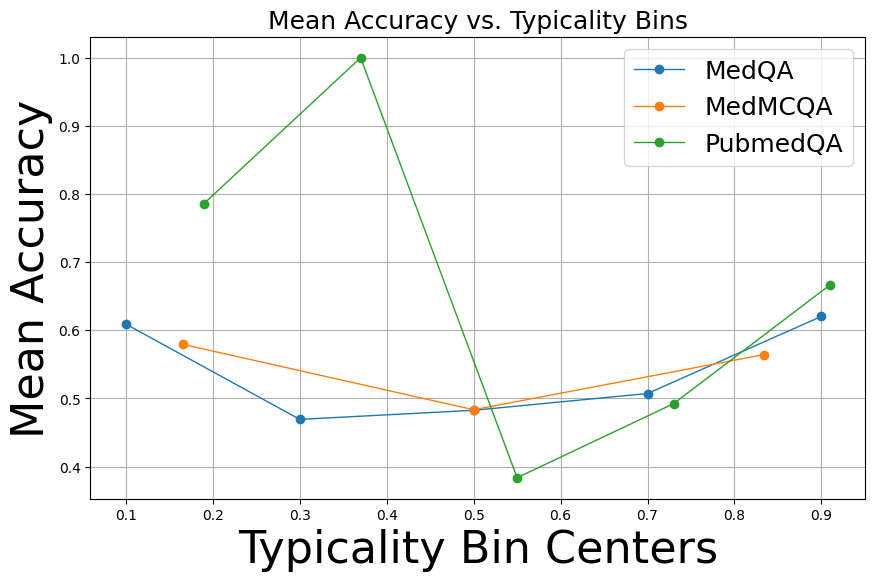

In [229]:
# Plot mean accuracy against atypicality bins
plt.figure(figsize=(10, 6))
plt.plot(bin_centers_scenario, mean_accuracy_scenario.values, marker='o', linewidth=1, label="MedQA")
plt.plot(bin_centers_scenario_medmcqa, mean_accuracy_scenario_medmcqa.values, marker='o', linewidth=1, label="MedMCQA")
plt.plot(bin_centers_scenario_pubmedqa, mean_accuracy_scenario_pubmedqa.values, marker='o', linewidth=1, label="PubmedQA")
plt.xlabel('Typicality Bin Centers', fontsize=32)
plt.ylabel('Mean Accuracy', fontsize=32)
plt.title('Mean Accuracy vs. Typicality Bins', fontsize=18)
plt.grid(True)
plt.legend(loc='upper right', fontsize=18)
plt.savefig('graphs/acc_vs_atypicality_scenario.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

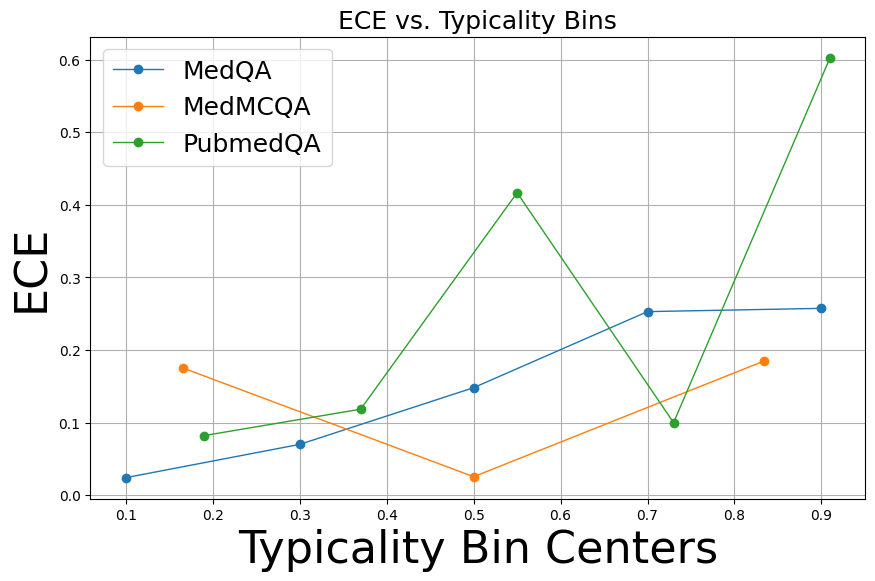

In [228]:
# Plot ECE against atypicality bins
plt.figure(figsize=(10, 6))
plt.plot(bin_centers_scenario, ece_scenario.values, marker='o', linewidth=1, label="MedQA")
plt.plot(bin_centers_scenario_medmcqa, ece_scenario_medmcqa.values, marker='o', linewidth=1, label="MedMCQA")
plt.plot(bin_centers_scenario_pubmedqa, ece_scenario_pubmedqa.values, marker='o', linewidth=1, label="PubmedQA")
# plt.plot(bin_centers_presentations, ece_presentations.values, marker='o', linewidth=1, label="Atypical Presentations")
plt.xlabel('Typicality Bin Centers', fontsize=32)
plt.ylabel('ECE', fontsize=32)
plt.title('ECE vs. Typicality Bins', fontsize=18)
plt.grid(True)
plt.legend(fontsize=18)
plt.savefig('graphs/ece_vs_atypicality_scenario.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

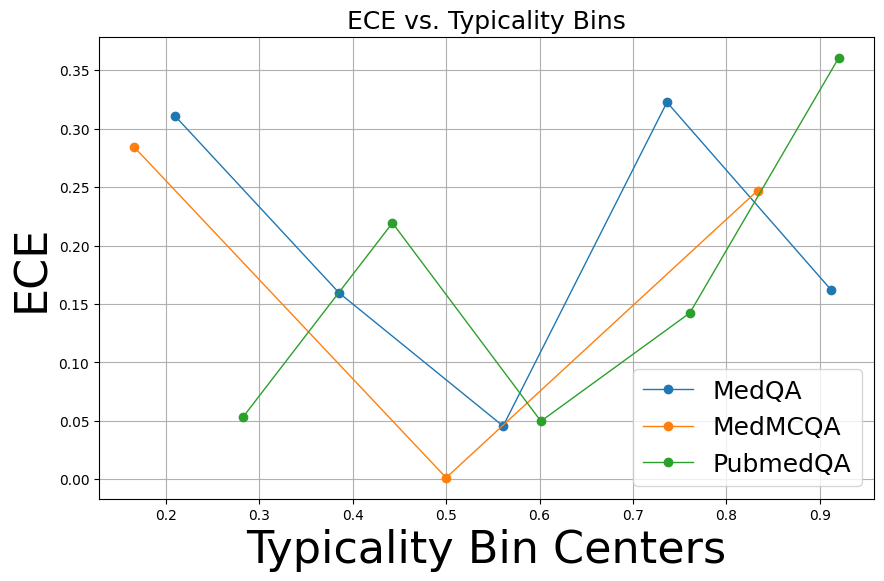

In [227]:
# Plot ECE against atypicality bins
plt.figure(figsize=(10, 6))
plt.plot(bin_centers_presentations, ece_presentations.values, marker='o', linewidth=1, label="MedQA")
plt.plot(bin_centers_presentations_medmcqa, ece_presentations_medmcqa.values, marker='o', linewidth=1, label="MedMCQA")
plt.plot(bin_centers_presentations_pubmedqa, ece_presentations_pubmedqa.values, marker='o', linewidth=1, label="PubmedQA")
# plt.plot(bin_centers_presentations, ece_presentations.values, marker='o', linewidth=1, label="Atypical Presentations")
plt.xlabel('Typicality Bin Centers', fontsize=32)
plt.ylabel('ECE', fontsize=32)
plt.title('ECE vs. Typicality Bins', fontsize=18)
plt.grid(True)
plt.legend(fontsize=18)
plt.savefig('graphs/ece_vs_atypicality_presentations.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

In [89]:
df_atypical_scenario['difficulty'] = df_atypical_scenario['Difficulty Score'].apply(lambda x: x[0])
df_atypical_presentations['difficulty'] = df_atypical_presentations['Difficulty Score'].apply(lambda x: x[0])

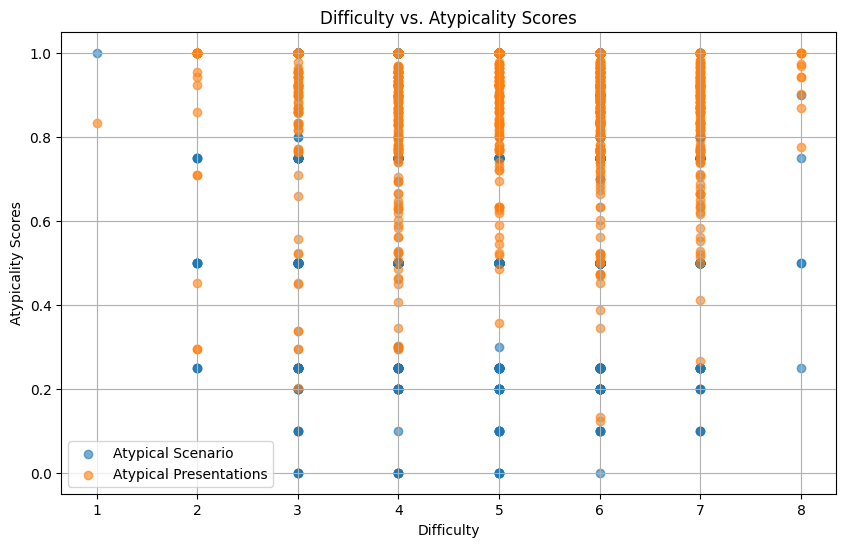

In [94]:
# Plot difficulty against atypicality scores
plt.figure(figsize=(10, 6))
plt.scatter(df_atypical_scenario['difficulty'], df_atypical_scenario['Atypicality'], alpha=0.6, label="Atypical Scenario")
plt.scatter(df_atypical_presentations['difficulty'], df_atypical_presentations['Atypicality'], alpha=0.6, label="Atypical Presentations")
plt.xlabel('Difficulty')
plt.ylabel('Atypicality Scores')
plt.title('Difficulty vs. Atypicality Scores')
plt.grid(True)
plt.legend()
plt.savefig('graphs/difficulty_vs_atypicality.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

In [63]:
# Define custom color palette
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6']

# Data from the table reformatted for the new requirement
data = {
    'Datasets': ['MedQA', 'MedQA', 'MedQA', 'MedQA', 'MedQA', 'MedQA',
                 'MedMCQA', 'MedMCQA', 'MedMCQA', 'MedMCQA', 'MedMCQA', 'MedMCQA',
                 'PubMedQA', 'PubMedQA', 'PubMedQA', 'PubMedQA', 'PubMedQA', 'PubMedQA'],
    'Methods': ['Vanilla', 'CoT', 'Atypical scenario', 'Atypical presentations', 'Consistency (k=3)', 'Average (k=3)',
                'Vanilla', 'CoT', 'Atypical scenario', 'Atypical presentations', 'Consistency (k=3)', 'Average (k=3)',
                'Vanilla', 'CoT', 'Atypical scenario', 'Atypical presentations', 'Consistency (k=3)', 'Average (k=3)'],
    'ECE': [0.351, 0.318, 0.084, 0.283, 0.408, 0.398,  # MedQA
            0.323, 0.357, 0.128, 0.152, 0.350, 0.350,  # MedMCQA
            0.251, 0.275, 0.115, 0.129, 0.335, 0.346]  # PubMedQA
}

df = pd.DataFrame(data)

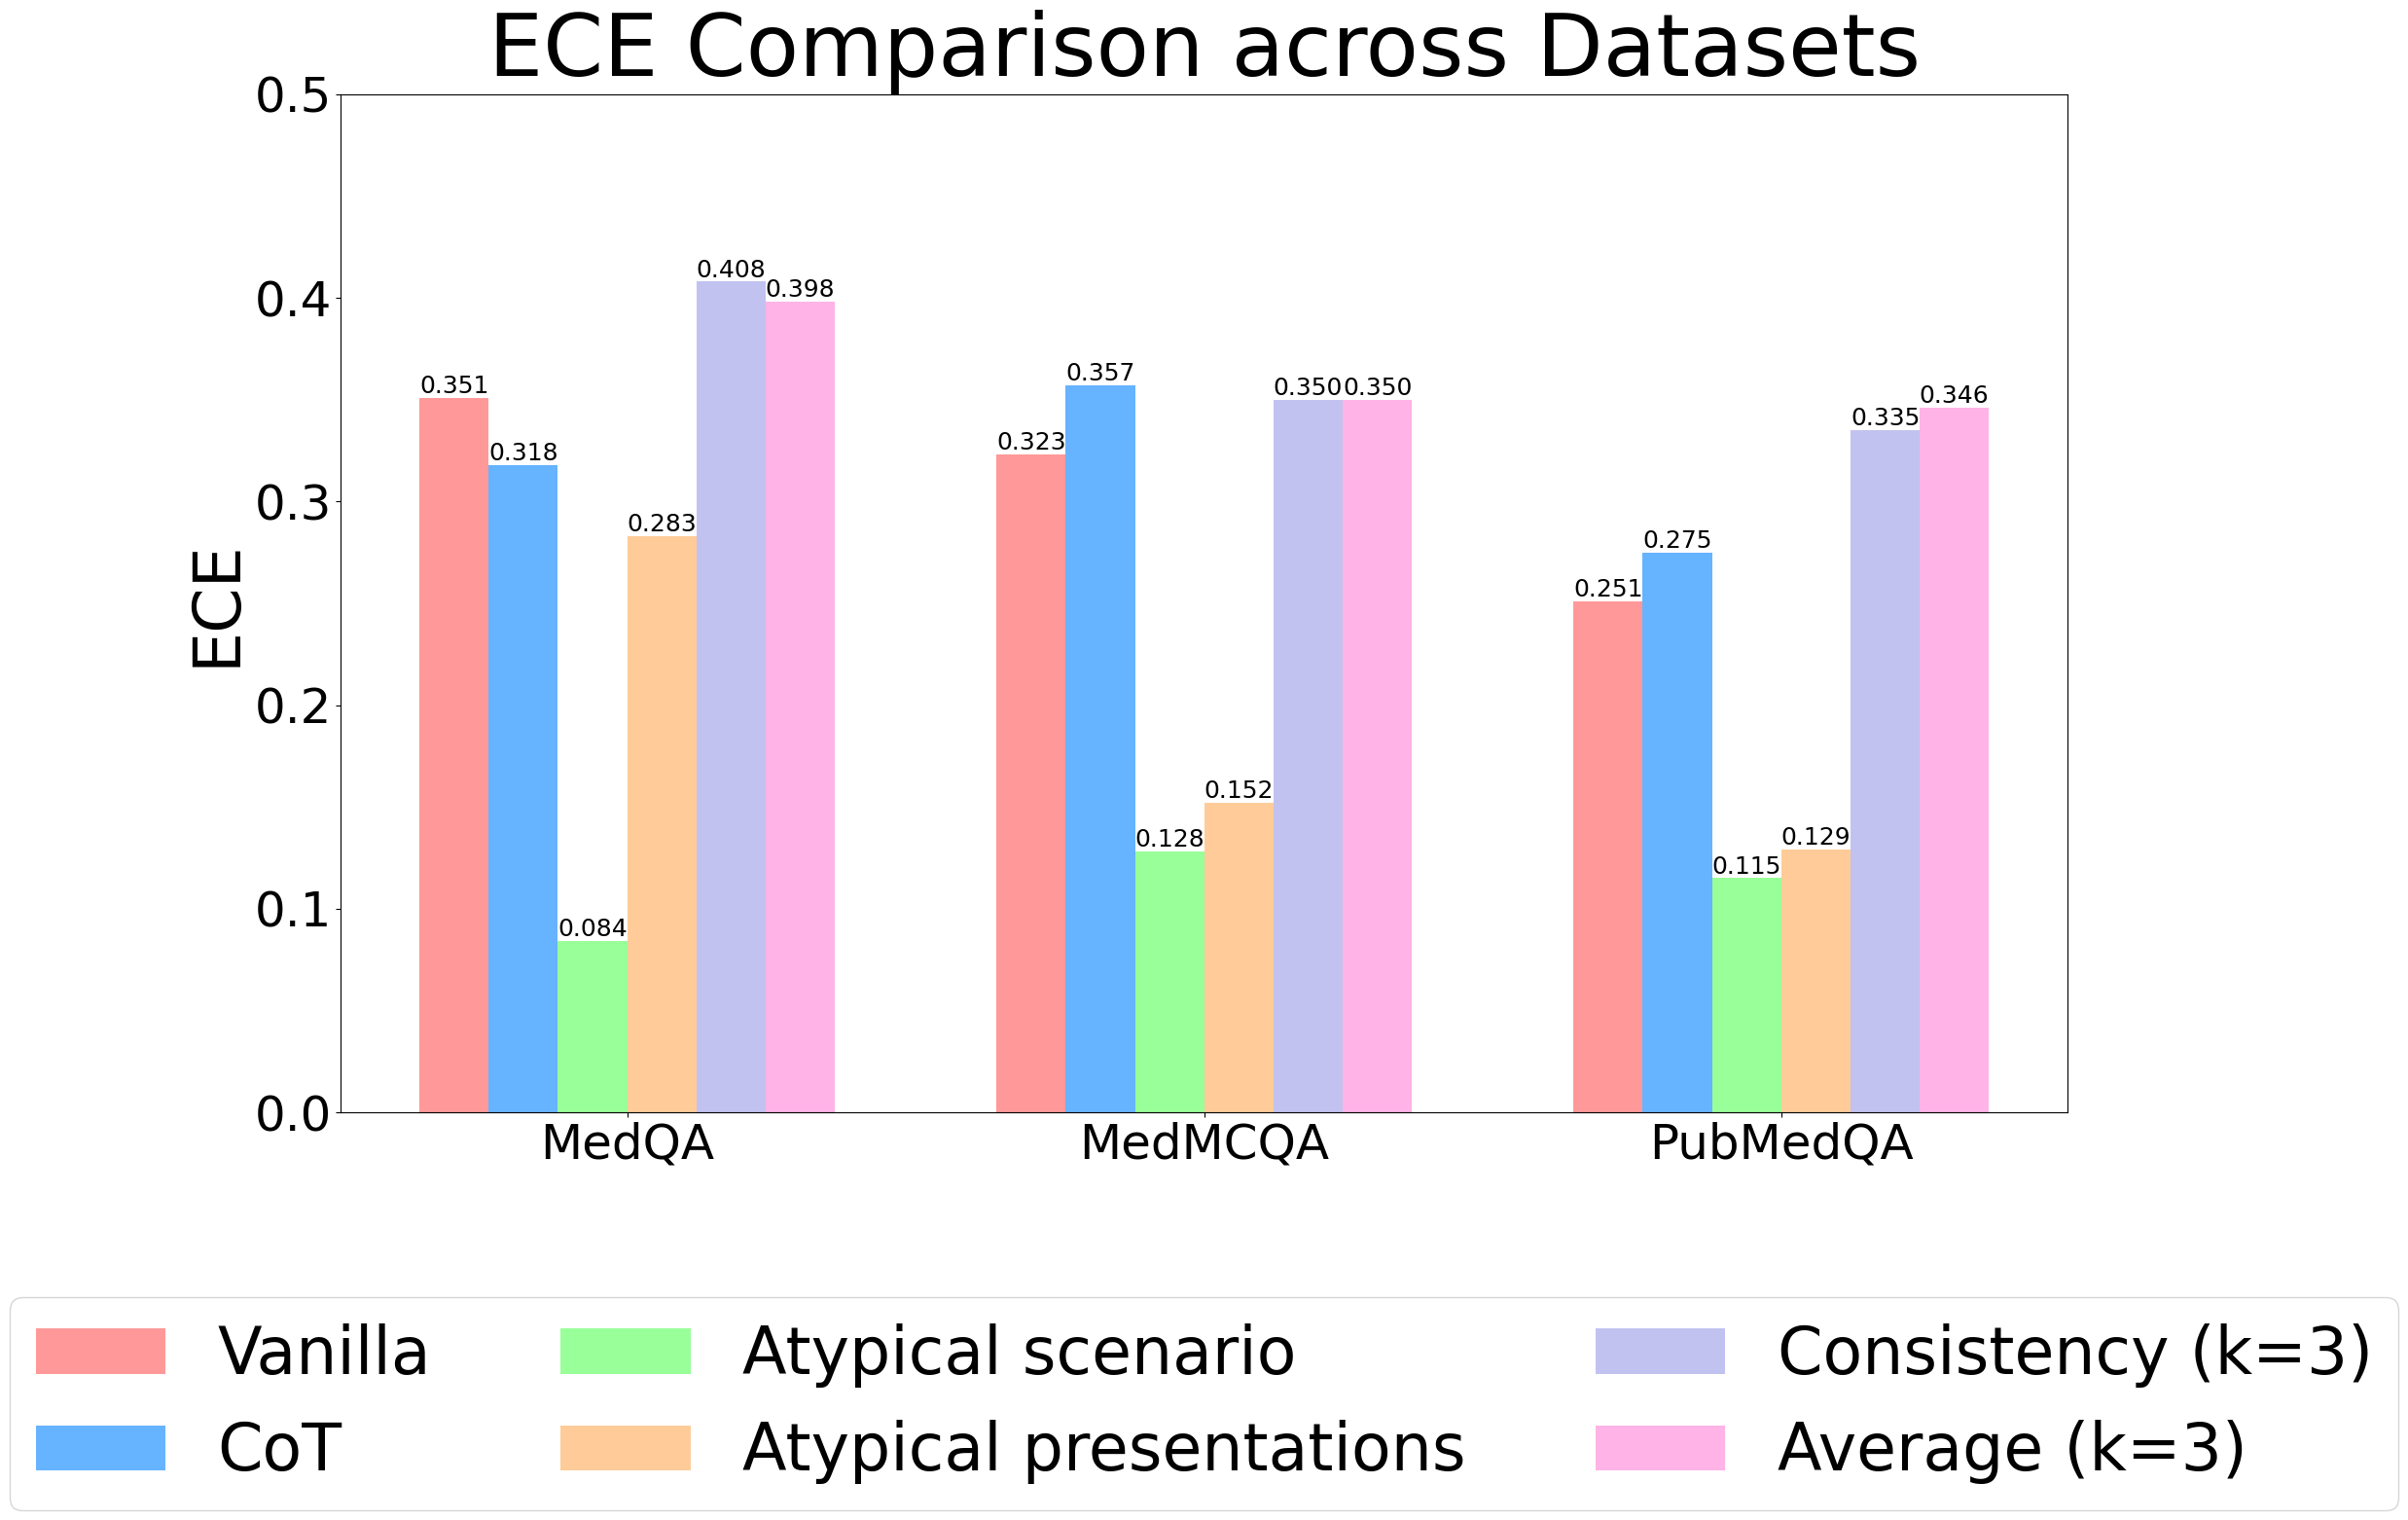

In [69]:
# Adjusting the legend position to avoid overlapping with the bars
bar_width = 0.12
datasets = ['MedQA', 'MedMCQA', 'PubMedQA']
index = range(len(datasets))
# Adjusting the legend position to avoid overlapping with the x-axis title
fig, ax = plt.subplots(figsize=(24, 16))

# Create bars for each method per dataset
for i, method in enumerate(df['Methods'].unique()):
    bar = plt.bar([j + i*bar_width for j in index], df[df['Methods'] == method]['ECE'], bar_width, label=method, color=colors[i])
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{height:.3f}', ha='center', va='bottom', fontsize=18)

# plt.xlabel('Datasets')
plt.ylabel('ECE', fontsize=48)
plt.title('ECE Comparison across Datasets', fontsize=64)
plt.xticks([r + 2.5*bar_width for r in index], datasets, fontsize=48)
ax.tick_params(axis='both', which='major', labelsize=36)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=48)  # Move legend further down
plt.ylim(0.00, 0.50)
plt.tight_layout()
plt.savefig('graphs/ece_per_datasets.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


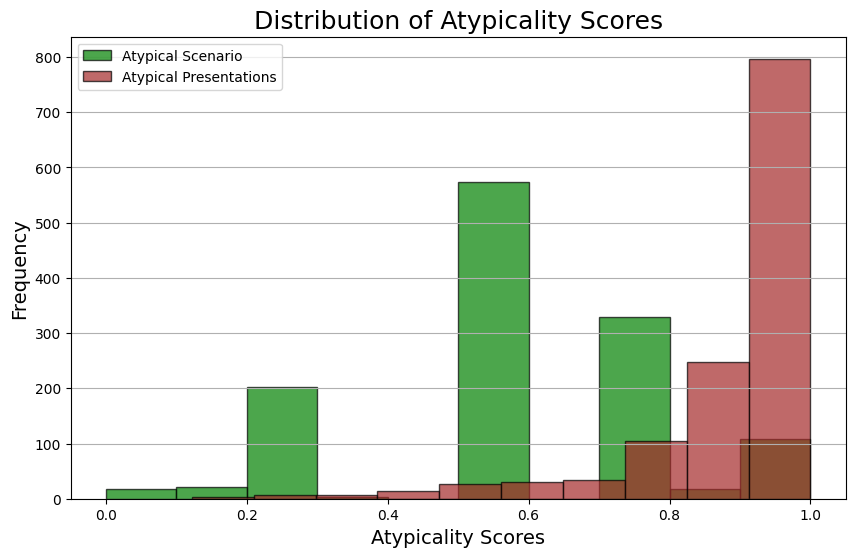

In [142]:
# Plotting the distribution of atypicality scores
plt.figure(figsize=(10, 6))
plt.hist(df_atypical_scenario['Atypicality'], bins=10, color='green', edgecolor='black', alpha=0.7, label="Atypical Scenario")
plt.hist(df_atypical_presentations['Atypicality'], bins=10, color='brown', edgecolor='black', alpha=0.7, label="Atypical Presentations")
plt.xlabel('Atypicality Scores', fontsize=32)
plt.ylabel('Frequency', fontsize=32)
plt.title('Distribution of Atypicality Scores', fontsize=18)
plt.grid(axis='y')
plt.legend()
plt.savefig('graphs/atypicality_distribution.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

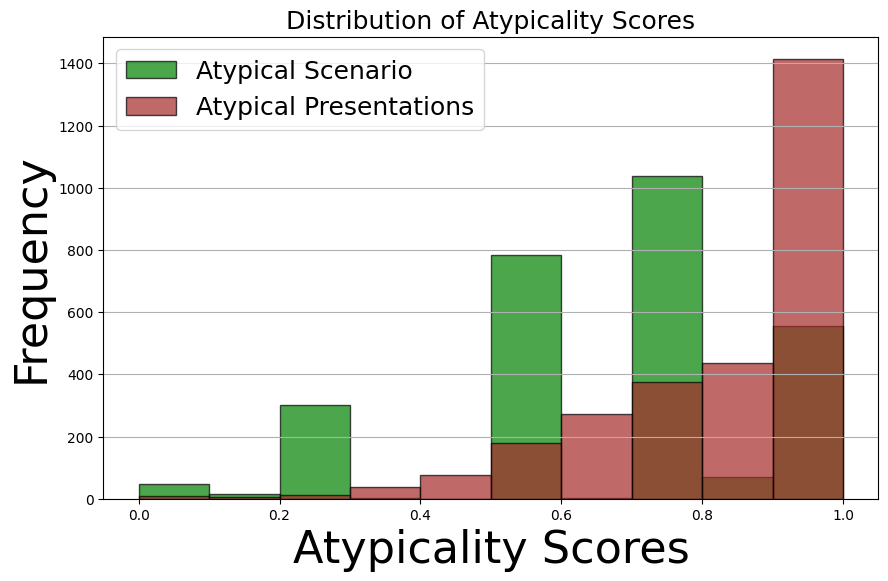

In [232]:
# Plotting the distribution of atypicality scores
plt.figure(figsize=(10, 6))
plt.hist(df_atypical_scenario_medmcqa['Atypicality'], bins=10, color='green', edgecolor='black', alpha=0.7, label="Atypical Scenario")
plt.hist(df_atypical_presentations_medmcqa['Atypicality'], bins=10, color='brown', edgecolor='black', alpha=0.7, label="Atypical Presentations")
plt.xlabel('Atypicality Scores', fontsize=32)
plt.ylabel('Frequency', fontsize=32)
plt.title('Distribution of Atypicality Scores', fontsize=18)
plt.grid(axis='y')
plt.legend(fontsize=18)
plt.savefig('graphs/atypicality_distribution_medmcqa.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

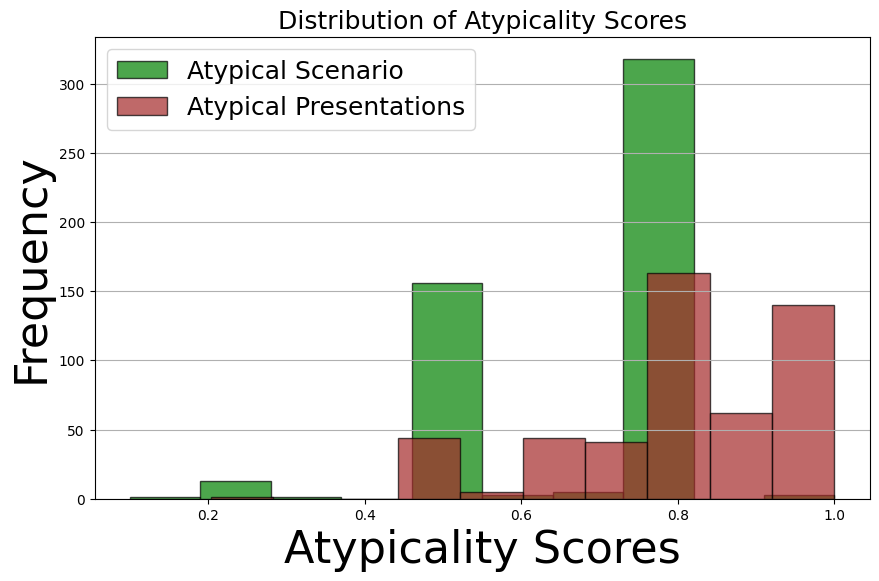

In [233]:
# Plotting the distribution of atypicality scores
plt.figure(figsize=(10, 6))
plt.hist(df_atypical_scenario_pubmedqa['Atypicality'], bins=10, color='green', edgecolor='black', alpha=0.7, label="Atypical Scenario")
plt.hist(df_atypical_presentations_pubmedqa['Atypicality'], bins=10, color='brown', edgecolor='black', alpha=0.7, label="Atypical Presentations")
plt.xlabel('Atypicality Scores', fontsize=32)
plt.ylabel('Frequency', fontsize=32)
plt.title('Distribution of Atypicality Scores', fontsize=18)
plt.grid(axis='y')
plt.legend(fontsize=18)
plt.savefig('graphs/atypicality_distribution_pubmedqa.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

In [145]:
df_atypical_presentations.head()

,Questions,Difficulty Score,Mean Difficulty Score,Correct Answers,Majority Predicted Answer,All Predicted Answers,Final Prediction,Consistency Confidence,Average Vanilla Confidence,Average Confidence,All Vanilla Confidence Scores,All Confidence Scores,Ground Truth Probability,Atypicality,atypicality_bin,accuracy,difficulty,Calibrated Confidence
0,A 21-year-old sexually active male complains o...,[5],5.0,D,D,[D],D,1.0,1.0,1.0,[80],[80.0],1.0,1.000000,"(0.875, 1.0]",1.0,5,0.800000
1,A 5-year-old girl is brought to the emergency ...,[6],6.0,A,A,[A],A,1.0,1.0,1.0,[80],[77.47200894938749],1.0,0.967890,"(0.875, 1.0]",1.0,6,0.774720
2,A 40-year-old woman presents with difficulty f...,[3],3.0,E,C,[C],C,1.0,1.0,1.0,[90],[86.28405589149901],0.0,0.957835,"(0.875, 1.0]",0.0,3,0.862841
3,A 37-year-old female with a history of type II...,[4],4.0,C,C,[C],C,1.0,1.0,1.0,[90],[82.03682819057057],1.0,0.907359,"(0.875, 1.0]",1.0,4,0.820368
4,A 19-year-old boy presents with confusion and ...,[4],4.0,A,C,[C],C,1.0,1.0,1.0,[90],[84.94110848201957],0.0,0.942149,"(0.875, 1.0]",0.0,4,0.849411


In [234]:
df_atypical_presentations['vanilla confidence'] = df_atypical_presentations['All Vanilla Confidence Scores'].apply(lambda x: x[0])
df_atypical_scenario['vanilla confidence'] = df_atypical_scenario['All Vanilla Confidence Scores'].apply(lambda x: x[0])

df_atypical_presentations_medmcqa['vanilla confidence'] = df_atypical_presentations_medmcqa['All Vanilla Confidence Scores'].apply(lambda x: x[0])
df_atypical_scenario_medmcqa['vanilla confidence'] = df_atypical_scenario_medmcqa['All Vanilla Confidence Scores'].apply(lambda x: x[0])

df_atypical_presentations_pubmedqa['vanilla confidence'] = df_atypical_presentations_pubmedqa['All Vanilla Confidence Scores'].apply(lambda x: x[0])
df_atypical_scenario_pubmedqa['vanilla confidence'] = df_atypical_scenario_pubmedqa['All Vanilla Confidence Scores'].apply(lambda x: x[0])

In [246]:
df_atypical_presentations['confidence_bin'] = pd.cut(df_atypical_presentations['vanilla confidence'], bins=5)
df_atypical_scenario['confidence_bin'] = pd.cut(df_atypical_scenario['vanilla confidence'], bins=5)

# Calculating mean atypicality for each bin
mean_atypicality_presentations = df_atypical_presentations.groupby('confidence_bin')['Atypicality'].mean()
mean_atypivality_scenario = df_atypical_scenario.groupby('confidence_bin')['Atypicality'].mean()

df_atypical_presentations_medmcqa['confidence_bin'] = pd.cut(df_atypical_presentations_medmcqa['vanilla confidence'], bins=5)
df_atypical_scenario_medmcqa['confidence_bin'] = pd.cut(df_atypical_scenario_medmcqa['vanilla confidence'], bins=5)

# Calculating mean atypicality for each bin
mean_atypicality_presentations_medmcqa = df_atypical_presentations_medmcqa.groupby('confidence_bin')['Atypicality'].mean()
mean_atypivality_scenario_medmcqa = df_atypical_scenario_medmcqa.groupby('confidence_bin')['Atypicality'].mean()

df_atypical_presentations_pubmedqa['confidence_bin'] = pd.cut(df_atypical_presentations_pubmedqa['vanilla confidence'], bins=5)
df_atypical_scenario_pubmedqa['confidence_bin'] = pd.cut(df_atypical_scenario_pubmedqa['vanilla confidence'], bins=5)

# Calculating mean atypicality for each bin
mean_atypicality_presentations_pubmedqa = df_atypical_presentations_pubmedqa.groupby('confidence_bin')['Atypicality'].mean()
mean_atypivality_scenario_pubmedqa = df_atypical_scenario_pubmedqa.groupby('confidence_bin')['Atypicality'].mean()

/tmp/ipykernel_124655/929999368.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_atypicality_presentations = df_atypical_presentations.groupby('confidence_bin')['Atypicality'].mean()
/tmp/ipykernel_124655/929999368.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_atypivality_scenario = df_atypical_scenario.groupby('confidence_bin')['Atypicality'].mean()
/tmp/ipykernel_124655/929999368.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future def

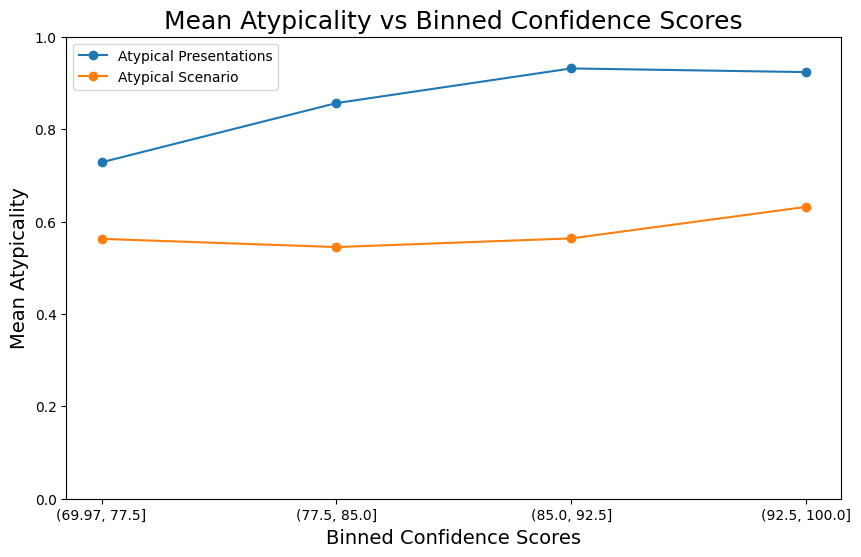

In [166]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(mean_atypicality_presentations.index.astype(str), mean_atypicality_presentations.values, marker='o', linestyle='-', label="Atypical Presentations")
plt.plot(mean_atypivality_scenario.index.astype(str), mean_atypivality_scenario.values, marker='o', linestyle='-', label='Atypical Scenario')
plt.xlabel('Binned Confidence Scores', fontsize=32)
plt.ylabel('Mean Atypicality', fontsize=32)
plt.title('Mean Atypicality vs Binned Confidence Scores', fontsize=18)
plt.ylim(0, 1)
plt.legend()
plt.savefig('graphs/atypicality_vs_confidence.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

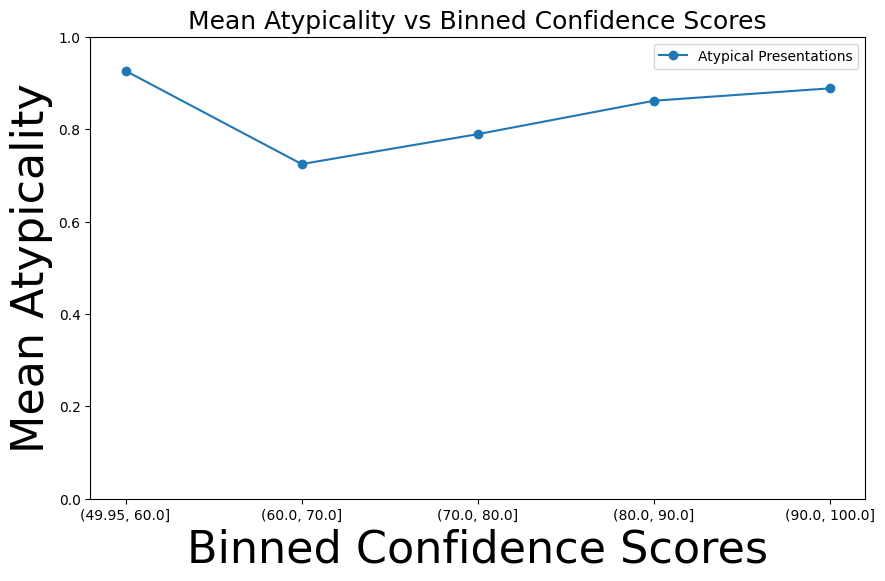

In [247]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(mean_atypicality_presentations_medmcqa.index.astype(str), mean_atypicality_presentations_medmcqa.values, marker='o', linestyle='-', label="Atypical Presentations")
# plt.plot(mean_atypivality_scenario_medmcqa.index.astype(str), mean_atypivality_scenario_medmcqa.values, marker='o', linestyle='-', label='Atypical Scenario')
plt.xlabel('Binned Confidence Scores', fontsize=32)
plt.ylabel('Mean Atypicality', fontsize=32)
plt.title('Mean Atypicality vs Binned Confidence Scores', fontsize=18)
plt.ylim(0, 1)
plt.legend()
# plt.savefig('graphs/atypicality_vs_confidence.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

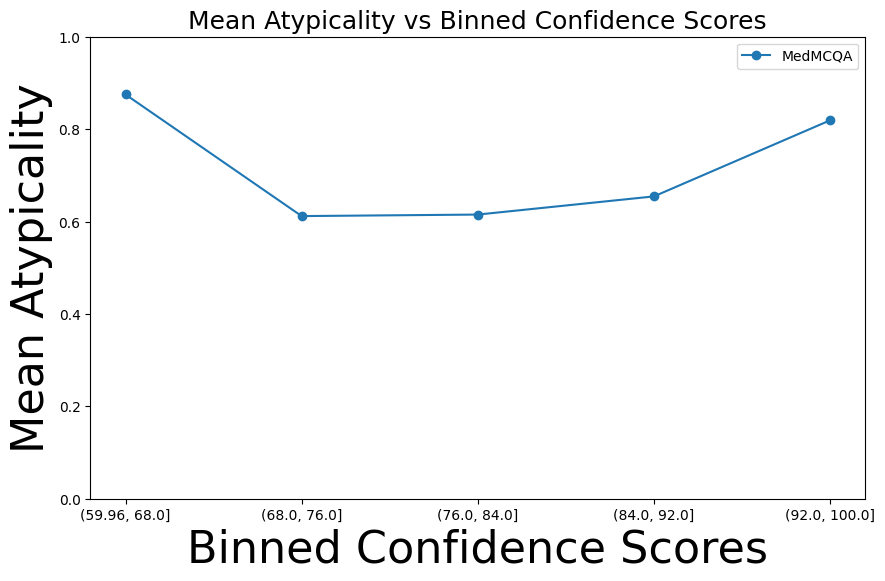

In [248]:
# Plotting the graph
plt.figure(figsize=(10, 6))
# plt.plot(mean_atypicality_presentations_medmcqa.index.astype(str), mean_atypicality_presentations_medmcqa.values, marker='o', linestyle='-', label="Atypical Presentations")
plt.plot(mean_atypivality_scenario_medmcqa.index.astype(str), mean_atypivality_scenario_medmcqa.values, marker='o', linestyle='-', label='MedMCQA')
plt.xlabel('Binned Confidence Scores', fontsize=32)
plt.ylabel('Mean Atypicality', fontsize=32)
plt.title('Mean Atypicality vs Binned Confidence Scores', fontsize=18)
plt.ylim(0, 1)
plt.legend()
# plt.savefig('graphs/atypicality_vs_confidence.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

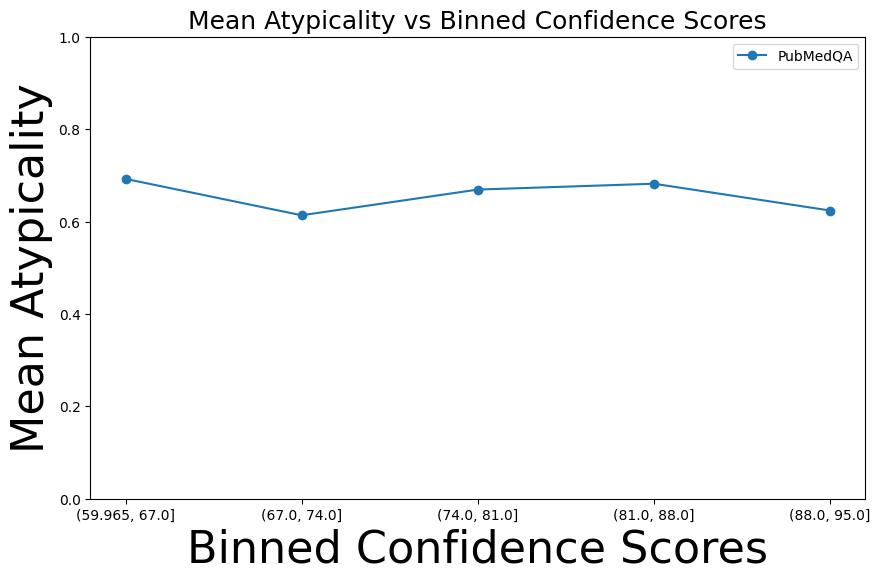

In [249]:
# Plotting the graph
plt.figure(figsize=(10, 6))
# plt.plot(mean_atypicality_presentations_medmcqa.index.astype(str), mean_atypicality_presentations_medmcqa.values, marker='o', linestyle='-', label="Atypical Presentations")
# plt.plot(mean_atypivality_scenario.index.astype(str), mean_atypivality_scenario.values, marker='o', linestyle='-', label='MedQA')
# plt.plot(mean_atypivality_scenario_medmcqa.index.astype(str), mean_atypivality_scenario_medmcqa.values, marker='o', linestyle='-', label='MedMCQA')
plt.plot(mean_atypivality_scenario_pubmedqa.index.astype(str), mean_atypivality_scenario_pubmedqa.values, marker='o', linestyle='-', label='PubMedQA')
plt.xlabel('Binned Confidence Scores', fontsize=32)
plt.ylabel('Mean Atypicality', fontsize=32)
plt.title('Mean Atypicality vs Binned Confidence Scores', fontsize=18)
plt.ylim(0, 1)
plt.legend()
# plt.savefig('graphs/atypicality_vs_confidence.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

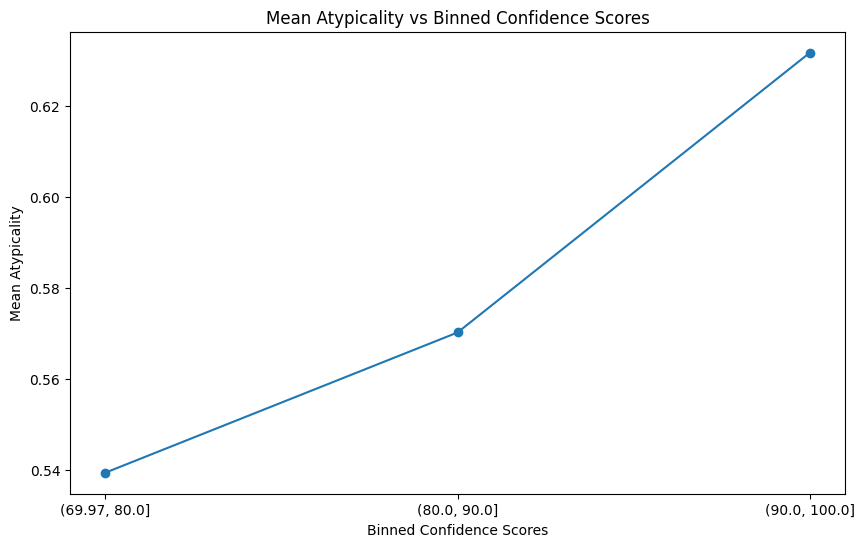

In [155]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(mean_atypivality_scenario.index.astype(str), mean_atypivality_scenario.values, marker='o', linestyle='-')
plt.xlabel('Binned Confidence Scores')
plt.ylabel('Mean Atypicality')
plt.title('Mean Atypicality vs Binned Confidence Scores')
plt.show()